In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import h5py
from pathlib import Path

def PhaseModel(n_channel, coordinates, roll=-14):
    ant_angles = np.arange(0, 360, 360//n_channel)

    x_array = 0.1 * np.cos(np.radians(ant_angles))
    y_array = 0.1 * np.sin(np.radians(ant_angles))
    x_coord, y_coord = coordinates[:, 0], coordinates[:, 1]

    d = np.sqrt(
        (x_array[:, np.newaxis] - x_coord[np.newaxis, :]) ** 2
        + (y_array[:, np.newaxis] - y_coord[np.newaxis, :]) ** 2
        )
    arctan = np.arctan2(
        y_array[:, np.newaxis] - y_coord[np.newaxis, :],
        x_array[:, np.newaxis] - x_coord[np.newaxis, :]
        )

    spatial = 2*np.pi * d[:, :, np.newaxis] / 0.01163
    phase = np.unwrap(np.roll(spatial-arctan[:, :, np.newaxis], roll, axis=0), axis=0)
    #phase = np.unwrap(np.roll(spatial-arctan[:, :, np.newaxis], roll, axis=0), axis=0)
    phase -= phase[0, :, :][np.newaxis, :, :]
    
    return -phase

def PhaseModelSynth(coordinates, roll=0):

    ant_angles = np.arange(0, 120, 1) * 3
    r_array = 0.1
    wavelength = 3e8 / 25.86e9

    x_array = r_array * np.cos(np.radians(ant_angles))
    y_array = r_array * np.sin(np.radians(ant_angles))
    x_coord, y_coord = coordinates[:, 0], coordinates[:, 1]

    d = np.sqrt(
        (x_array[:, np.newaxis] - x_coord[np.newaxis, :]) ** 2
        + (y_array[:, np.newaxis] - y_coord[np.newaxis, :]) ** 2
        )
    arctan = np.arctan2(
        y_array[:, np.newaxis] - y_coord[np.newaxis, :],
        x_array[:, np.newaxis] - x_coord[np.newaxis, :]
        )

    spatial = 2*np.pi * d / wavelength
    phase = np.unwrap(np.roll(spatial+arctan, roll, axis=0), axis=0)
    phase -= phase[0, :][np.newaxis, :]
    
    return -phase

def PhaseModelCRES(coordinates, roll=0):

    ant_angles = np.arange(0, 60, 1) * 6
    r_array = 0.1
    wavelength = 3e8 / 25.86e9

    x_array = r_array * np.cos(np.radians(ant_angles))
    y_array = r_array * np.sin(np.radians(ant_angles))
    x_coord, y_coord = coordinates[:, 0], coordinates[:, 1]

    d = np.sqrt(
        (x_array[:, np.newaxis] - x_coord[np.newaxis, :]) ** 2
        + (y_array[:, np.newaxis] - y_coord[np.newaxis, :]) ** 2
        )
    arctan = np.arctan2(
        y_array[:, np.newaxis] - y_coord[np.newaxis, :],
        x_array[:, np.newaxis] - x_coord[np.newaxis, :]
        )

    spatial = 2*np.pi * d / wavelength
    phase = np.unwrap(np.roll(-spatial+arctan, roll, axis=0), axis=0)
    phase -= phase[0, :][np.newaxis, :]
    
    return phase

def MagModelCRES(r):
    
    x1 = r
    y1 = 0
    ant_angles = np.arange(0, 60, 1) * 6
    
    r_array = 0.1
    x_array = r_array * np.cos(np.radians(ant_angles))
    y_array = r_array * np.sin(np.radians(ant_angles))
    
    d = np.sqrt((x1-x_array)**2 + (y1-y_array)**2)
    
    return 1 + (d**2-r_array**2) / r_array**2
    
    
    

def phase_offset_correction(data_phases, model_phases, find_peak_height=0.5, find_peak_prom=0.3):
    
    phase_diff = data_phases-model_phases
    phase_diff = np.convolve(phase_diff, np.ones(5)/5, mode='valid')
    phase_diff_diff = np.convolve(np.diff(phase_diff), np.ones(5)/5, mode='same')
    peaks = signal.find_peaks(abs(phase_diff_diff), height=find_peak_height, prominence=find_peak_prom)
    #print(peaks)
    peak_inds = peaks[0]
    #print(peak_inds)
    peak_heights = peaks[1]['peak_heights']
    phase_correction = np.zeros(data_phases.size)
    n = 1
    for j in range(peak_inds.size):
        ind_j = peak_inds[j]
        if peak_inds.size == 1:
            approximate_discont_size = np.mean(phase_diff[ind_j+3:]) - np.mean(phase_diff[0:ind_j+3])
            n = np.round(approximate_discont_size/(2*np.pi), 0)
            phase_correction[ind_j+3:] += -1*2*n*np.pi
        elif peak_inds.size > 1:
            if j == 0: # first peak
                approximate_discont_size = np.mean(
                    phase_diff[ind_j+3:peak_inds[j+1]]+3) - np.mean(phase_diff[0:ind_j+3])
                n = np.round(approximate_discont_size/(2*np.pi), 0)
                #print(n)
                phase_correction[ind_j+3:] += -1*2*n*np.pi
            elif j == peak_inds.size - 1: # last peak
                approximate_discont_size = np.mean(
                    phase_diff[ind_j+3:]) - np.mean(phase_diff[peak_inds[j-1]+3:ind_j+3])
                n = np.round(approximate_discont_size/(2*np.pi), 0)
                #print(n)
                phase_correction[ind_j+3:] += -1*2*n*np.pi
            else: # intermediate peaks
                approximate_discont_size = np.mean(
                    phase_diff[ind_j+3:peak_inds[j+1]+3]) - np.mean(phase_diff[peak_inds[j-1]+3:ind_j+3])
                n = np.round(approximate_discont_size/(2*np.pi), 0)
                phase_correction[ind_j+3:] += -1*2*n*np.pi

    return phase_correction

In [3]:
jugaad_data = Path.home()/'group'/'project'/'datasets'/'data'/'230412_jugaad_analysis'/'230412_jugaad_data.h5'
jugaad_data = h5py.File(jugaad_data, 'r')

pennstate_data = Path.home()/'group'/'project'/'datasets'/'data'/\
'230412_jugaad_analysis'/'230102_synca1_5slot_scan_fft_corrected_phases.npy'
pennstate_data = np.load(pennstate_data)

cresana_data = np.load(Path.home()/'group'/'project'/'datasets'/'data'/'cresana_magphase.npy')




# jugaad

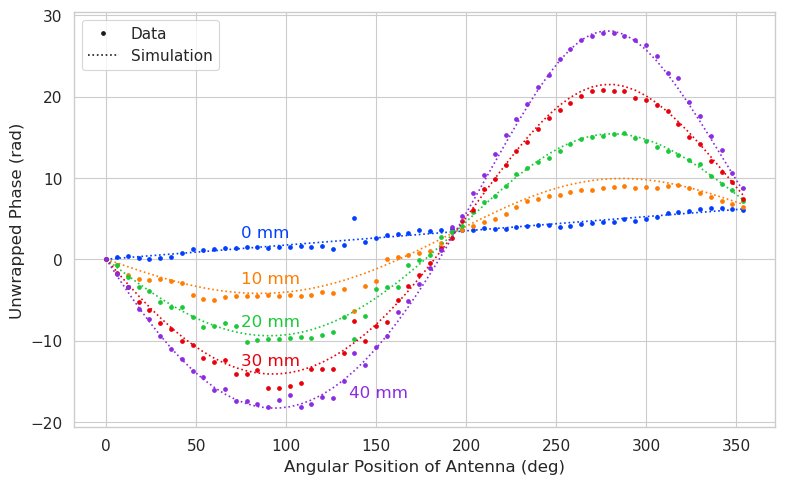

In [26]:
radii = np.arange(0, 50, 10)
test_axial_position = 0

clist = sns.color_palette('bright', n_colors=11)
sns.set_theme(context='paper', style='whitegrid', font_scale=1.25)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

text_pos = [
    (75,2.75),
    (75,-3),
    (75,-8.25),
    (75,-13),
    (135,-17)
]
for k, rad in enumerate(radii):
    if rad<10:
        test_key_rad = f'r0{rad}'
    else:
        test_key_rad = f'r{rad}'
    
    if test_axial_position < 10:
        test_key_axial = f'z0{test_axial_position}'
    else:
        test_key_axial = f'z{test_axial_position}'
        
    test_key = test_key_rad + test_key_axial
    test_data = jugaad_data[test_key][:]
    test_position = np.array([[0.001 * rad, 0.],])
    # loop over frequencies
    for i, n in enumerate([76]):#enumerate(np.arange(0,test_data.shape[1],1)):

        test_phases = np.unwrap(np.angle(test_data[:,n,1,0]), axis=0)
        test_phases -= test_phases[0]


        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction
        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction
        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction

        differences = test_phases - PhaseModel(60, test_position)[:,0,0]
        for j in range(differences.size):
            if abs(differences[j]) > 3.5:
                while(abs(differences[j]) > 3.5):
                    differences[j] -= np.sign(differences[j])*2*np.pi
                    
        
        ax.plot(np.arange(0,360,6),test_phases, ls='None', marker='.', color=clist[k%11], label=f'{radii[k]} mm')
        #ax.plot(np.arange(0,360,6),differences, ls='-', marker='.', color=clist[k%11], label=f'{radii[k]} mm')
        ax.plot(np.arange(0,360,6),PhaseModel(60,test_position)[:,0,0],ls=':',marker='None',color=clist[k%11])
        
        ax.text(text_pos[k][0], text_pos[k][1], f'{radii[k]} mm', color=clist[k%11])
sim_line, = ax.plot([],[],label='Simulation',color='k',ls=':',marker='None')
data_line, = ax.plot([],[],label='Data',color='k',ls='None',marker='.')
ax.legend([data_line, sim_line],['Data', 'Simulation'], loc=2)
ax.set_xlabel('Angular Position of Antenna (deg)')
ax.set_ylabel('Unwrapped Phase (rad)')
#ax.set_title('S21 Phase vs SYNCA Radial Position')

plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230411_jugaad_measured_phases_z0', dpi=128)

# synthetic

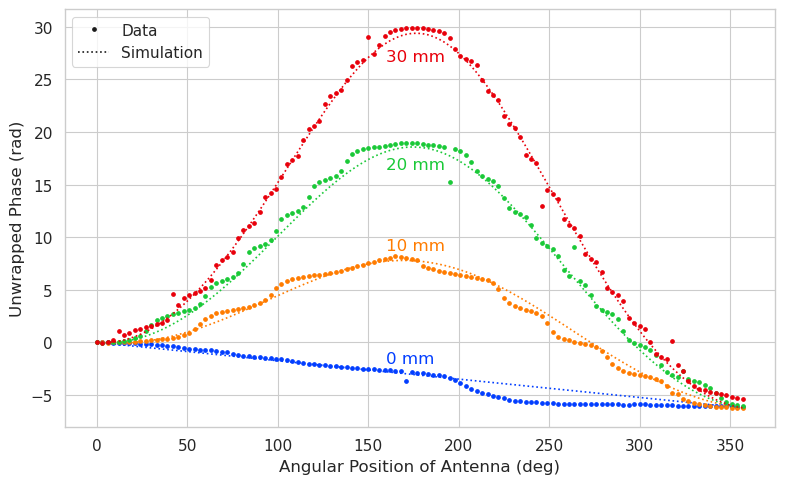

In [55]:
i_ax = 3

radii = np.arange(10, -40, -5) * 0.001
axii = np.arange(-15,55,5)
i_axii = np.arange(3, 9, 1) # 0 to 25 mm

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

text_pos = [
    (160,-2),
    (160,8.75),
    (160,16.5),
    (160,26.75)
]

clist = sns.color_palette('bright')
sns.set_theme(context='paper', style='whitegrid', font_scale=1.25)
for j, i_rad in enumerate(np.arange(2,10,2)):
    
    
    i_phase = np.unwrap(np.angle(pennstate_data[i_ax, i_rad, :]))
    x_position = np.array([radii[i_rad]])
    y_position = np.array([0])
    coordinates = np.array([x_position, y_position]).T
    
    model_phases = PhaseModelSynth(coordinates)[:, 0]
    phase_corrections = phase_offset_correction(i_phase, model_phases)
    i_phase += phase_corrections
    phase_corrections = phase_offset_correction(i_phase, model_phases)
    i_phase += phase_corrections
    phase_differences = i_phase - model_phases
    
    #ax.plot(np.arange(0,360,3),phase_differences, ls='-', marker='.', color=clist[i_rad],label=f'{-1*radii[i_rad]*1000} mm')
    ax.plot(np.arange(0,360,3),i_phase, ls='None', marker='.', color=clist[j],label=f'{-1*radii[i_rad]*1000} mm')
    ax.plot(np.arange(0,360,3),model_phases, color=clist[j], ls=':',)
    ax.text(text_pos[j][0], text_pos[j][1], f'{abs(int(radii[i_rad]*1000))} mm', color=clist[j])
    
sim_line, = ax.plot([],[],label='Simulation',color='k',ls=':',marker='None')
data_line, = ax.plot([],[],label='Data',color='k',ls='None',marker='.')
ax.legend([data_line, sim_line],['Data', 'Simulation'], loc=2)
#ax.legend(title='SYNCA X-Position', loc=(1.01, 0.1))
ax.set_xlabel('Angular Position of Antenna (deg)')
ax.set_ylabel('Unwrapped Phase (rad)')
#ax.set_title(f'Synthetic Array Unwrapped Phase Error'+ '\n'+f'Single Frequency, SYNCA Z-Position = {axii[i_ax]} mm')

plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230411_synthetic_array_measured_phases', dpi=128)

# cresana

In [6]:
cresana_data

array([(0.   , [3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09, 3.8391348e-09], [-7.82332599e-01, -6.77612841e-01, -5.72893083e-01, -4.68173325e-01, -3.63453567e-0

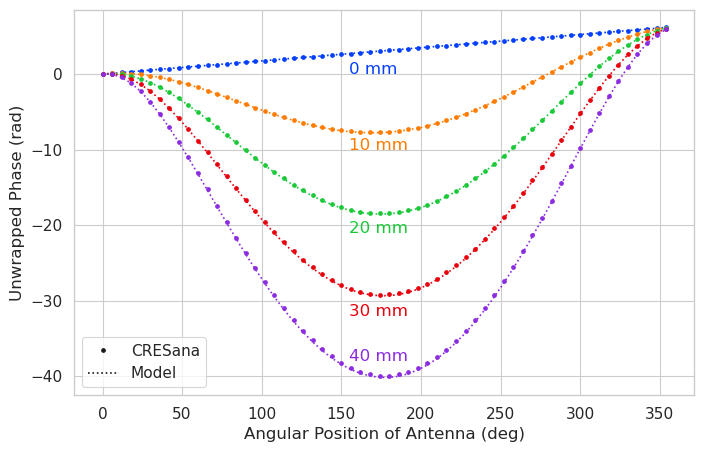

In [34]:
rad_ind = np.arange(0,50,10) # 0,10,...40
test_axial_position = 0

clist = sns.color_palette('bright', n_colors=11)
sns.set_theme(context='paper', style='whitegrid', font_scale=1.25)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

text_pos = [
    (155,0),
    (155,-10),
    (155,-21),
    (155,-32),
    (155,-38)
]
for i,k in enumerate(rad_ind):
    
    temp_phase = np.unwrap(cresana_data[k]['phase'])
    temp_phase -=temp_phase[0]
    
    coordinates = np.array([[k*0.001], [0]]).T
    model_phases = PhaseModelCRES(coordinates)[:, 0]

    ax.plot(np.arange(0,360,6),temp_phase, ls='None', marker='.', color=clist[i])
    #ax.plot(np.arange(0,360,6),differences, ls='-', marker='.', color=clist[k%11], label=f'{radii[k]} mm')
    ax.plot(np.arange(0,360,6),model_phases,ls=':',marker='None',color=clist[i])
        
    ax.text(text_pos[i][0], text_pos[i][1], f'{rad_ind[i]} mm', color=clist[i])
sim_line, = ax.plot([],[],label='Simulation',color='k',ls=':',marker='None')
data_line, = ax.plot([],[],label='Data',color='k',ls='None',marker='.')
ax.legend([data_line, sim_line],['CRESana', 'Model'], loc=3)
ax.set_xlabel('Angular Position of Antenna (deg)')
ax.set_ylabel('Unwrapped Phase (rad)')
#ax.set_title('S21 Phase vs SYNCA Radial Position')

#plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230504_cresana_phases', dpi=128)

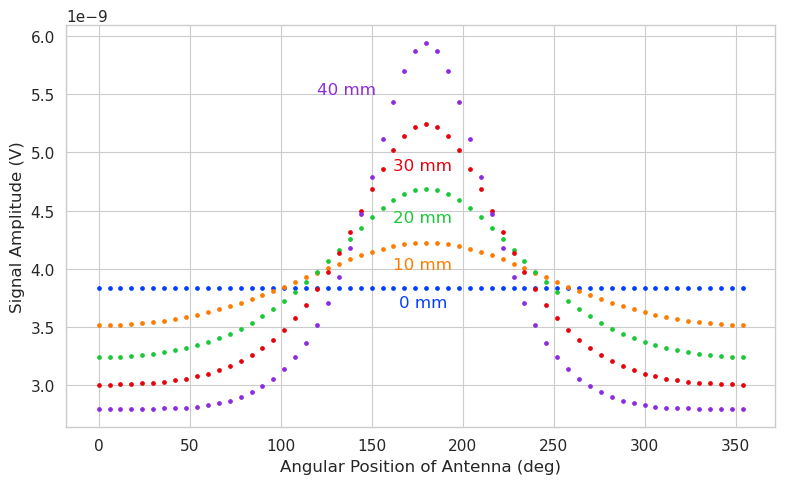

In [27]:
rad_ind = np.arange(0,50,10) # 0,10,...40
test_axial_position = 0

clist = sns.color_palette('bright', n_colors=11)
sns.set_theme(context='paper', style='whitegrid', font_scale=1.25)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

text_pos = [
    (165,3.675e-9),
    (162,4e-9),
    (162,4.4e-9),
    (162,4.85e-9),
    (120,5.5e-9)
]
for i,k in enumerate(rad_ind):
    
    temp_mag = np.roll(cresana_data[k]['mag'], 30)
    
    coordinates = np.array([[k*0.001], [0]]).T
    model_phases = PhaseModelCRES(coordinates)[:, 0]

    ax.plot(np.arange(0,360,6),temp_mag, ls='None', marker='.', color=clist[i])
    #ax.plot(np.arange(0,360,6),differences, ls='-', marker='.', color=clist[k%11], label=f'{radii[k]} mm')
    #ax.plot(np.arange(0,360,6),model_phases,ls=':',marker='None',color=clist[i])
        
    ax.text(text_pos[i][0], text_pos[i][1], f'{rad_ind[i]} mm', color=clist[i])
#sim_line, = ax.plot([],[],label='Simulation',color='k',ls=':',marker='None')
#data_line, = ax.plot([],[],label='Data',color='k',ls='None',marker='.')
#ax.legend([data_line, sim_line],['CRESana', 'Model'], loc=3)
ax.set_xlabel('Angular Position of Antenna (deg)')
ax.set_ylabel('Signal Amplitude (V)')
#ax.set_title('S21 Phase vs SYNCA Radial Position')

plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230508_cresana_mags', dpi=128)

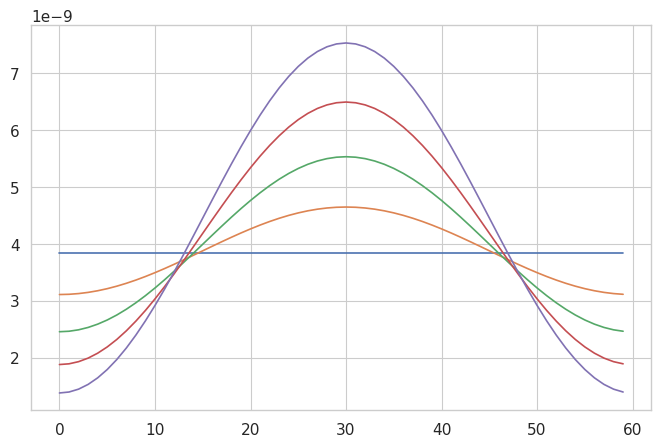

In [59]:
clist = sns.color_palette('bright', n_colors=11)
sns.set_theme(context='paper', style='whitegrid', font_scale=1.25)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

rad_ind = np.arange(0,50,10) # 0,10,...40
test_axial_position = 0

cresmag0 = np.mean(cresana_data[0]['mag'],)
modelmag0 = np.mean(MagModelCRES(0))

conversion = cresmag0 / modelmag0

for i,k in enumerate(rad_ind):
    
    ax.plot(conversion*np.roll(MagModelCRES(k*1e-3),0))

